In [8]:
# I tried looking at keras pre defined functions for evaluvation but nothing seems simpler than directly finding the metrics
# https://yanfengliux.medium.com/the-confusing-metrics-of-ap-and-map-for-object-detection-3113ba0386ef
#

In [9]:
# The metric average precision (AP) is used in the papers, and is explained well in: 
# Recall: 
# Precision: precision is measuring the percentage of correct positive predictions among all predictions made
# Recall: recall is measuring the percentage of correct positive predictions among all positive cases in reality.
# In our study recall >> Precision for the class 1. I.e. We cant afford to miss a human debry.
# Okay, both recall as well precision are calculated on class basis. 
# I would suggest, just call the model many times and find the predicted value and the true value.
# This is fine for finding the recall and precision, but not sure for AP. Ap is the area under the precision-recall graph
# And as per the webpage, in order to get multiple recall and precision values you nee different thresholds

In [10]:
# IS AP a good metric, but invariably all the papers use it, so have to use it for evaluvating the model.  

In [11]:
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from keras import layers

import glob
from pathlib import Path
from PIL import Image
import numpy as np

### In this notebook, we focus on finding the recall

In [12]:
#/Users/krish/Library/CloudStorage/GoogleDrive-krishthephysicist@gmail.com/My Drive/ljmu/1.data
root_path =  r'/Users/krish/ljmu/'
result_root = root_path + '3.results/13112022-ResNet50-afo/'
#Path(result_root).mkdir(parents=True, exist_ok=True)

In [13]:

model = keras.models.load_model(result_root+'15112022-2354-ResNet_after_tiling+augmentation_10epochs_afo')

In [14]:
test_data = pd.read_csv(root_path + '1.data/afo/tiled/afo_test_df.csv')

In [15]:
test_data['humans'].value_counts()

0    11113
1     4488
Name: humans, dtype: int64

In [16]:
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [17]:
def predicter(file_path):
    
    #print(file_path)
    im = Image.open(file_path)
    test_input = np.array(im, dtype=np.uint8)
    if len(test_input.shape) == 3:
        test_input = resize_and_rescale(test_input)
        out = model(tf.reshape(test_input,(1,224,224,3)))

        return np.array(out)[0][0] 
    else:
        return 'out_of_shape'

In [18]:
test_data['prediction'] = test_data.name.apply(predicter)

In [19]:
test_data

,Unnamed: 0,name,humans,number_of_humans,prediction
0,16419,/Users/krish/ljmu/1.data/afo/tiled/ts/f_110_1_...,1,7,0.988440
1,29033,/Users/krish/ljmu/1.data/afo/tiled/false/r3_17...,0,0,0.042353
2,3873,/Users/krish/ljmu/1.data/afo/tiled/ts/c_107_0_...,1,3,0.994451
3,14376,/Users/krish/ljmu/1.data/afo/tiled/ts/a_345_0_...,1,5,0.949421
4,17601,/Users/krish/ljmu/1.data/afo/tiled/false/a_113...,0,0,0.533144
...,...,...,...,...,...
15596,27307,/Users/krish/ljmu/1.data/afo/tiled/false/k9_54...,0,0,0.018900
15597,6432,/Users/krish/ljmu/1.data/afo/tiled/ts/r3_461_1...,1,1,0.087330
15598,8555,/Users/krish/ljmu/1.data/afo/tiled/false/a_102...,0,0,0.072634
15599,36418,/Users/krish/ljmu/1.data/afo/tiled/false/d_444...,0,0,0.430123


In [20]:
result_root = root_path + '3.results/15112022-metrics_calculator/'
Path(result_root).mkdir(parents=True, exist_ok=True)

In [22]:
test_data.to_csv(result_root +'test_output.csv')

In [23]:
# https://kawahara.ca/how-to-compute-truefalse-positives-and-truefalse-negatives-in-python-for-binary-classification-problems/

In [54]:
tp,fp,tn,fn = 0,0,0,0
for i in range(test_data.shape[0]):
    if (test_data.iloc[i]['humans'] == int(test_data.iloc[i]['prediction'].round())) and (test_data.iloc[i]['humans']==0):
        tn +=1
    elif (test_data.iloc[i]['humans'] == int(test_data.iloc[i]['prediction'].round())) and (test_data.iloc[i]['humans']==1):
        tp +=1
    elif (test_data.iloc[i]['humans'] != int(test_data.iloc[i]['prediction'].round())) and (test_data.iloc[i]['humans']==1):
        fp+=1
    elif (test_data.iloc[i]['humans'] != int(test_data.iloc[i]['prediction'].round())) and (test_data.iloc[i]['humans']==0):
        fn+=1
    


In [55]:
print(tp,fp,tn,fn,test_data.shape[0])

3941 547 10922 191 15601


In [56]:
tp+fp+tn+fn

15601

In [57]:
print('recall:',tp/(tp+fn))
print('precision',tp/(tp+fp))
print('accuracy:',(tp+tn)/test_data.shape[0])

recall: 0.9537754114230397
precision 0.8781194295900179
accuracy: 0.9526953400423049


In [28]:
int(test_data.iloc[0]['prediction'].round(1))

1

**After doing this, I feel we can dont need the keras to get the area under the curve, we can vary the threshold in the array of elif statements** 

In [ ]:
model.predict()

In [ ]:
y_pred_keras = model.predict(X_test).ravel()

In [29]:
# https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
# Using this we are going to find the AP
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

NameError: name 'X_test' is not defined

In [30]:
from sklearn.metrics import roc_curve


In [31]:
test_data = pd.read_csv(result_root+'test_output.csv')


In [33]:
test_data.iloc[:]['prediction'].values

array([0.98844016, 0.04235325, 0.99445117, ..., 0.07263373, 0.43012255,
       0.05961371])

In [34]:
y_true = test_data.iloc[:]['humans'].values
y_pred = test_data.iloc[:]['prediction'].values
roc_curve(y_true,y_pred)

(array([0.       , 0.       , 0.       , ..., 0.9429497, 0.9429497,
        1.       ]),
 array([0.00000000e+00, 2.22816399e-04, 4.23351159e-03, ...,
        9.99777184e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.99994874e+00, 9.99948740e-01, 9.99856230e-01, ...,
        5.24312960e-03, 5.23103540e-03, 1.49001700e-04]))

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true,y_pred)

0.9713709297761628

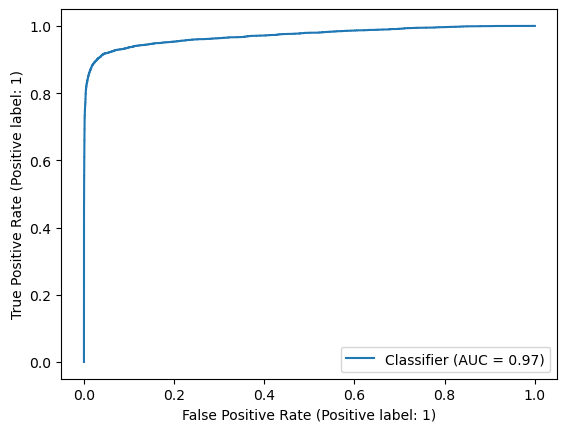

In [36]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_true, y_pred)

In [43]:
y_pred

array([0.98844016, 0.04235325, 0.99445117, ..., 0.07263373, 0.43012255,
       0.05961371])

In [49]:
round(0.05961371,)

0

In [50]:
y_pred.round()

array([1., 0., 1., ..., 0., 0., 0.])

In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,y_pred.round())

array([[10922,   191],
       [  547,  3941]])

In [53]:
from sklearn.metrics import recall_score
recall_score(y_true,y_pred.round())

0.8781194295900179

In [58]:
from sklearn.metrics import precision_score
precision_score(y_true,y_pred.round())

0.9537754114230397